### Exercise 4.7

Let state $S$ be $S=(S_1, S_2)$. Rental request $L=(L_1,L_2)$, Return request $T=(T_1,T_2)$. Action $A$, Reward $R$.

$$\begin{aligned}
P(S', R|S, A) &= \sum_{L,T} P(S', R, L, T | S, A) \\
   &= \sum_{L,T} P(S', R | L, T, S, A) P( L, T | S, A) \\ 
   &= \sum_{L,T} P(S', R | L, T, S, A) P( L ) P(T) \\
   &= \sum_{L,T \mbox{ that leads to }S', R} P(L) P(T) \\
   &= \sum_{L,T \mbox{ that leads to }S', R} P(L_1) P(T_1)P(L_2)P(T_2)
\end{aligned}$$

| |Shop 1| Shop 2|
|---- |- |-|
|Rental($L$)| Poisson(3) | Poisson(4)|
|Return($T$)| Poisson(3) | Poisson(2)|

Note that 

$(1 - poisson.cdf(12, 3)) = 1.6(10^{-5})$

$(1 - poisson.cdf(10, 2)) = 8.3(10^{-6})$


$(1 - poisson.cdf(14, 4)) = 2.0(10^{-5})$

So we constrain $L_1, T_1 \in [0, 12], L_2 \in [0,14], T_2 \in[0,10]$

For value iteration, we need to pick the best action given a starting state, so our dynamics table will be a nested dictionary in the following structure $(S_1, S_2) \rightarrow A \rightarrow (S', r) \rightarrow P(S',R|S,A)$

In [113]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import collections
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
from collections import namedtuple
from numpy.random import default_rng
from scipy.stats import poisson
rng = default_rng()

In [136]:
def car_rental_sim(s1, s2, moved_from_one, l1, l2, t1, t2):
    if moved_from_one >= 0:
        cars_to_move = min(s1, moved_from_one)
        sp1, sp2 = s1 - cars_to_move, min(20, s2 + cars_to_move)
    else:
        cars_to_move = min(s2, - moved_from_one)
        sp1, sp2 = min(20, s1 + cars_to_move), s2 - cars_to_move

    reward = -2 * cars_to_move

    actual_l1, actual_l2 = min(sp1, l1), min(sp2, l2)
    reward += 10 * (actual_l1 + actual_l2)

    sp1 = min(20, sp1 - actual_l1 + t1)
    sp2 = min(20, sp2 - actual_l2 + t2)

    # return s', r
    return ((sp1, sp2), reward)

In [143]:
# Test car rental sim
test_cases = [ # (Input,  Expected output)
    # Move more cars than available
    [(3, 3, 5, 0, 0, 0, 0), ((0, 6), -2 * 3)],
    [(3, 3, -5, 0, 0, 0, 0), ((6, 0), -2 * 3)],
    # More rental request than cars available
    [(3, 3, 5, 0, 7, 0, 0), ((0, 0), -2 * 3 + 10 * 6)],
    [(3, 3, -5, 7, 0, 0, 0), ((0, 0), -2 * 3 + 10 * 6)],
    # Move more cars than shop can contain
    [(18, 18, -5, 0, 0, 0, 0), ((20, 13), -2 * 5)],
    [(18, 18, 5, 0, 0, 0, 0), ((13, 20), -2 * 5)],
    # Return more cars than shop can contain
    [(18, 18, 0, 0, 0, 5, 0), ((20, 18), 0)],
    [(18, 18, 0, 0, 0, 0, 5), ((18, 20), 0)],
]

for test_case in test_cases:
    assert car_rental_sim(*test_case[0]) == test_case[1], \
           "For {}, Expected {}, But get {}".format(test_case[0],  test_case[1], car_rental_sim(*test_case[0]))

In [145]:
sim = CarRentalOriginalSim()
poss_3 = [poisson.pmf(k, 3)  for k in range(13)]
poss_4 = [poisson.pmf(k, 4)  for k in range(15)]
poss_2 = [poisson.pmf(k, 2)  for k in range(11)]
p = {}

In [146]:
# Build dynamics
initial_states = tqdm([(s1, s2) for s1 in range(21) for s2 in range(21)])
for (s1, s2) in initial_states:
    for a in range(-5, 6):
        for (l1, l2) in product(range(13), range(15)):
            for (t1, t2) in product(range(13), range(11)):
                if (s1, s2) not in p:
                    p[(s1, s2)] = {}
                
                if a not in p[(s1,s2)]:
                    p[(s1,s2)][a] = {}
                
                sp, r = car_rental_sim(s1, s2, a, l1, l2, t1, t2)
                if (sp, r) not in  p[(s1, s2)][a]:
                    p[(s1, s2)][a][(sp, r)] = 0
                p[(s1, s2)][a][(sp, r)] += poss_3[l1] * poss_3[t1] * poss_4[l2] * poss_2[t2]


100%|████████████████████████████████████████████████████████████████████████████████| 441/441 [07:46<00:00,  1.06s/it]


Above is the plot of poisson pmf over the integers, notice that the probability quickly drop to near 0. We will prune the the 3 columns up to row (5, 6, 7).

In [147]:
# Save computed dynamics
import pickle

with open('dynamics_4_7.pickle', 'wb') as h:
    pickle.dump(p, h, protocol=pickle.HIGHEST_PROTOCOL)

In [148]:
# Variables
epochs = 25
gamma = 0.9
v = np.zeros((21, 21))
states_to_iter = [(s1, s2) for s1 in range(21) for s2 in range(21)]
dv_history = []

In [150]:
# Value Iteration
for epoch in tqdm(range(epochs)):
    dv = -1
    for (s1, s2) in states_to_iter:
        max_action_return = 0
        for a in range(-5, 6):
            total = 0
            for (sp, r) in p[(s1, s2)][a]:
                total += p[(s1, s2)][a][(sp, r)] * (r + gamma * v[sp[0], sp[1]])
            max_action_return = max(max_action_return, total)
        # record largest dv in each epoch
        dv = max(dv, abs(max_action_return - v[s1, s2]))
        v[s1, s2] = max_action_return
    print("Epoch {} , loss: {}".format(epoch, dv))
    dv_history.append(dv)

  2%|█▍                                                                                 | 1/60 [00:19<19:01, 19.34s/it]

Epoch 0 , loss: 100000.0


  3%|██▊                                                                                | 2/60 [00:38<18:37, 19.27s/it]

Epoch 1 , loss: 111.47267338753213


  5%|████▏                                                                              | 3/60 [00:58<18:23, 19.36s/it]

Epoch 2 , loss: 87.93294550185291


  7%|█████▌                                                                             | 4/60 [01:17<18:10, 19.48s/it]

Epoch 3 , loss: 66.2025544500105


  8%|██████▉                                                                            | 5/60 [01:37<17:55, 19.56s/it]

Epoch 4 , loss: 49.95194911251377


 10%|████████▎                                                                          | 6/60 [01:57<17:37, 19.58s/it]

Epoch 5 , loss: 38.528163960779295


 12%|█████████▋                                                                         | 7/60 [02:16<17:17, 19.57s/it]

Epoch 6 , loss: 31.325967260802884


 13%|███████████                                                                        | 8/60 [02:36<16:54, 19.51s/it]

Epoch 7 , loss: 25.7535507754518


 15%|████████████▍                                                                      | 9/60 [02:55<16:36, 19.54s/it]

Epoch 8 , loss: 21.126615164527266


 17%|█████████████▋                                                                    | 10/60 [03:14<16:10, 19.41s/it]

Epoch 9 , loss: 17.311213908278376


 18%|███████████████                                                                   | 11/60 [03:34<15:48, 19.36s/it]

Epoch 10 , loss: 14.175791516532342


 20%|████████████████▍                                                                 | 12/60 [03:53<15:26, 19.30s/it]

Epoch 11 , loss: 11.605636910004762


 22%|█████████████████▊                                                                | 13/60 [04:12<15:03, 19.22s/it]

Epoch 12 , loss: 9.500839519467945


 23%|███████████████████▏                                                              | 14/60 [04:31<14:43, 19.21s/it]

Epoch 13 , loss: 7.777299649419888


 25%|████████████████████▌                                                             | 15/60 [04:50<14:26, 19.26s/it]

Epoch 14 , loss: 6.366367129406569


 27%|█████████████████████▊                                                            | 16/60 [05:10<14:14, 19.43s/it]

Epoch 15 , loss: 5.211587699919221


 28%|███████████████████████▏                                                          | 17/60 [05:30<14:02, 19.60s/it]

Epoch 16 , loss: 4.266323158977173


 30%|████████████████████████▌                                                         | 18/60 [05:50<13:48, 19.74s/it]

Epoch 17 , loss: 3.4925612151968153


 32%|█████████████████████████▉                                                        | 19/60 [06:10<13:31, 19.80s/it]

Epoch 18 , loss: 2.859214610173183


 33%|███████████████████████████▎                                                      | 20/60 [06:30<13:16, 19.92s/it]

Epoch 19 , loss: 2.340788934840475


 35%|████████████████████████████▋                                                     | 21/60 [06:50<12:57, 19.93s/it]

Epoch 20 , loss: 1.9164106432041308


 37%|██████████████████████████████                                                    | 22/60 [07:10<12:33, 19.84s/it]

Epoch 21 , loss: 1.5690014551785794


 38%|███████████████████████████████▍                                                  | 23/60 [07:29<12:10, 19.73s/it]

Epoch 22 , loss: 1.284590277596351


 40%|████████████████████████████████▊                                                 | 24/60 [07:49<11:45, 19.59s/it]

Epoch 23 , loss: 1.051749477484634


 42%|██████████████████████████████████▏                                               | 25/60 [08:08<11:21, 19.48s/it]

Epoch 24 , loss: 0.8611286239878382


 43%|███████████████████████████████████▌                                              | 26/60 [08:27<10:59, 19.40s/it]

Epoch 25 , loss: 0.7050693492628852


 43%|███████████████████████████████████▌                                              | 26/60 [08:34<11:12, 19.78s/it]


KeyboardInterrupt: 

<AxesSubplot:title={'center':'Value function convergence'}, xlabel='Epoch', ylabel='Loss'>

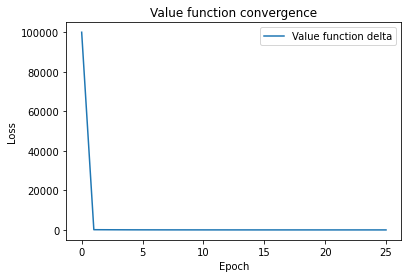

In [160]:
pd.DataFrame({"Value function delta": dv_history}).plot(ylabel="Loss", xlabel="Epoch", title="Value function convergence")

In [152]:
# Compute policy
pi = np.zeros((21, 21))
for (s1, s2) in states_to_iter:
    max_action_return = 0
    best_action = 0
    for a in range(-5, 6):
        total = 0
        for (sp, r) in p[(s1, s2)][a]:
            total += p[(s1, s2)][a][(sp, r)] * (r + gamma * v[sp[0], sp[1]])
        if total > max_action_return:  
            max_action_return = total
            best_action = a
    pi[s1, s2] = best_action

<Figure size 3600x3600 with 0 Axes>

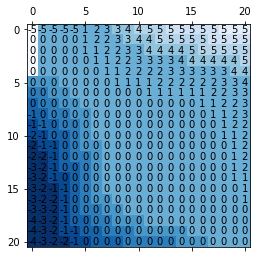

In [153]:
# Plot contour of Policy
pi_int = pi.astype(np.int)
fig=plt.figure(figsize=(50, 50))

plt.matshow(pi_int, cmap=plt.cm.Blues)
for i in range(21):
    for j in range(21):
        c = pi_int[i, j]
        plt.text(i, j, str(c), va='center', ha='center')

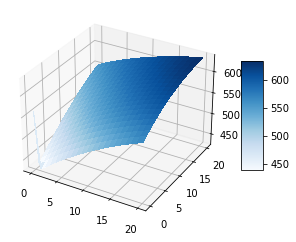

In [159]:
# Visualize value function V
from mpl_toolkits.mplot3d import Axes3D

S1 = np.arange(0, 21)
S2 = np.arange(0, 21)
X, Y = np.meshgrid(S1, S2)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, v, rstride=1, cstride=1, cmap=plt.cm.Blues, linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()